# 年輪データの状態空間モデル
* ローカルレベルモデル

In [1]:
import os
from cmdstanpy import CmdStanModel
from pathlib import Path
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

/home/karinog/miniconda3/envs/cmdstanpy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データ読込み

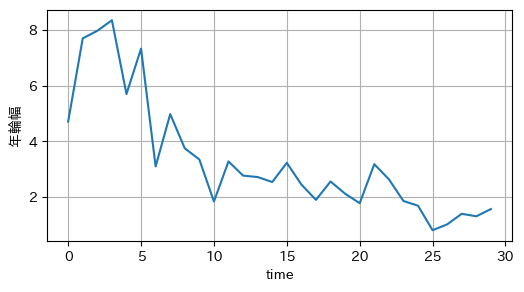

In [2]:
df = pd.read_csv("../data/nenrin.data", header=None)
df.columns = ["data"]

plt.figure(figsize=(6,3))
plt.plot(df["data"])
plt.xlabel("time")
plt.ylabel("年輪幅")
plt.grid()
plt.show()

In [3]:
stanfile = "../models_ts/local_level_nenrin.stan"
model = CmdStanModel(stan_file=stanfile)

15:34:26 - cmdstanpy - INFO - compiling stan file /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/local_level_nenrin.stan to exe file /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/local_level_nenrin
15:34:45 - cmdstanpy - INFO - compiled model executable: /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/local_level_nenrin


In [4]:
N_tr = df["data"].shape[0]
y_tr = df["data"].values
data = {
    "N_tr": N_tr,
    "y_tr": y_tr
}

In [5]:
fit = model.sample(
    data=data,
    iter_warmup=300, iter_sampling=1000, chains=3, show_console=False,
    adapt_delta=0.999,
    max_treedepth=20,
)

15:34:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       


15:34:45 - cmdstanpy - INFO - CmdStan done processing.


In [6]:
# 念の為診断
print(fit.diagnose())

Processing csv files: /tmp/tmpux90r4v2/local_level_nenrinwef9bs1l/local_level_nenrin-20230825153445_1.csv, /tmp/tmpux90r4v2/local_level_nenrinwef9bs1l/local_level_nenrin-20230825153445_2.csv, /tmp/tmpux90r4v2/local_level_nenrinwef9bs1l/local_level_nenrin-20230825153445_3.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



## 結果の確認

In [7]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-13.49380,0.716925,8.063620,-24.823300,-13.61810,-3.98433,126.506,219.629,1.019260
alpha[1],5.73719,0.026133,0.725817,4.576840,5.72487,6.91139,771.418,1339.270,1.002680
alpha[2],7.01347,0.016569,0.582411,6.047780,7.01931,7.95156,1235.560,2145.080,1.000210
alpha[3],7.44195,0.020173,0.625099,6.361450,7.48123,8.40318,960.218,1667.050,1.001020
alpha[4],7.40866,0.026307,0.661104,6.249640,7.43411,8.43033,631.553,1096.450,1.002600
...,...,...,...,...,...,...,...,...,...
y_tr_hat[26],1.16434,0.019007,0.935575,-0.368124,1.13468,2.76622,2422.760,4206.190,0.999714
y_tr_hat[27],1.18864,0.017862,0.960138,-0.334507,1.15210,2.79056,2889.440,5016.390,0.999281
y_tr_hat[28],1.36001,0.019786,0.986337,-0.232677,1.36139,2.98310,2485.120,4314.440,0.999954
y_tr_hat[29],1.35921,0.021493,0.973279,-0.190065,1.35329,3.03615,2050.520,3559.920,1.003070


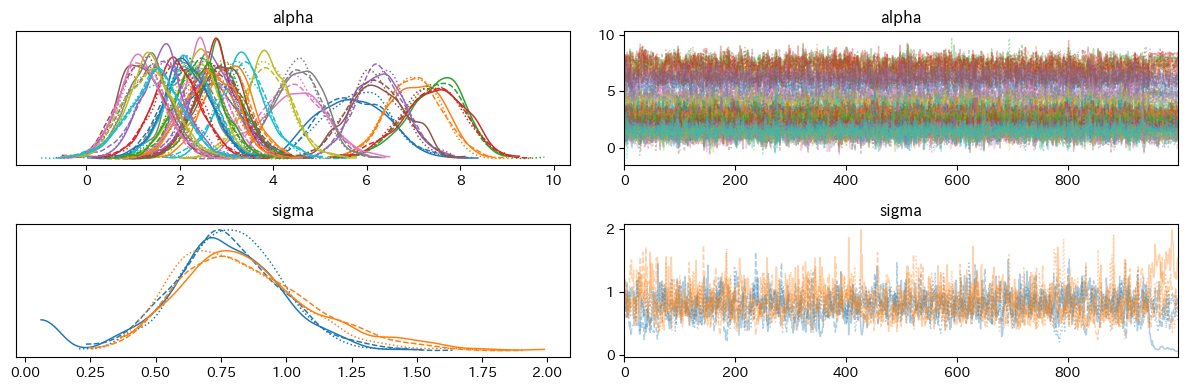

In [8]:
output = az.from_cmdstanpy(posterior=fit)
az.plot_trace(output, var_names=["alpha","sigma"])
plt.tight_layout()

## EAP推定
* 対数尤度が「異常度」の指標になる
* $\log L(y | \hat y, \sigma)$の意味
    * モデルが$\hat y$を推定したときにデータが$y$を取りうる確率の対数
    * 発生確率が小さくなるほど対数尤度も小さくなる
    * 発生確率が小さい＝めったに起こらない＝異常！と考える

In [10]:
samples = fit.stan_variables()

alpha = samples["alpha"].mean(0)
sigma = samples["sigma"].mean(0)
alpha, sigma

(array([5.7371856 , 7.0134692 , 7.44194694, 7.40866093, 6.28905591,
        6.1799197 , 4.43371073, 4.52355686, 3.86850788, 3.33809392,
        2.66363133, 2.9886687 , 2.8338143 , 2.75994651, 2.69821251,
        2.84062004, 2.48668121, 2.20878183, 2.35335313, 2.2030155 ,
        2.14797845, 2.60853298, 2.3926327 , 1.92886408, 1.62633878,
        1.19208852, 1.19153988, 1.34074658, 1.35880353, 1.4730379 ]),
 array([0.77051126, 0.84171441]))

In [11]:
y_tr_hat_lower, y_tr_hat_upper = np.quantile(samples["y_tr_hat"], [0.025,0.975], axis=0)
y_tr_hat_mean = samples["y_tr_hat"].mean(0)

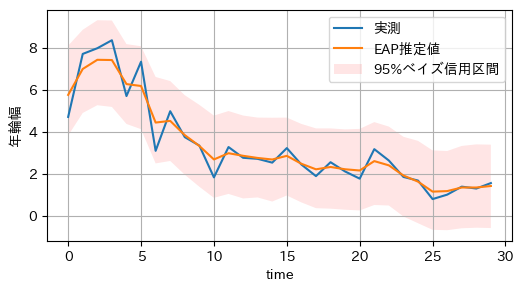

In [12]:
plt.figure(figsize=(6,3))
plt.plot(y_tr, label="実測")
plt.plot(y_tr_hat_mean, label="EAP推定値")
plt.fill_between(
    np.arange(N_tr), y1=y_tr_hat_lower, y2=y_tr_hat_upper, 
    alpha=0.1, color="r", edgecolor=None, label="95%ベイズ信用区間"
)
plt.xlabel("time")
plt.ylabel("年輪幅")
plt.grid()
plt.legend()
plt.show()

EOF